In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import random

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import PIL.Image

In [29]:
IM_WIDTH = 90
IM_HEIGHT = 90
BOX_WIDTH = 10
BOX_HEIGHT = 10
MARGIN = 3
N_CLASSES = 3
N_CHANNELS = 3


def make_batch_generator(g, n_batch):
    assert n_batch > 0
    while True:
        Xs, ys = [], []
        for _ in range(n_batch):
            X, y = next(g)
            Xs.append(X)
            ys.append(y)
        yield np.stack(Xs), np.stack(ys)


def make_test_generator(seed, im_width, im_height, box_width, box_height, margin, n_classes):
    assert im_width > 1, im_width
    assert im_height > 1, im_height
    rng = random.Random(seed)
    w, h = (im_width - 1)//2, (im_height - 1)//2
    imax = im_height - box_height
    jmax = im_width - (box_width + margin + box_width)
    while True:
        while True:
            i = rng.randint(0, imax - 1)
            j = rng.randint(0, jmax - 1)
            if not ((i <= h) and (j <= w)):
                break
        yield make_X_y(rng, i, j, im_width, im_height, box_width, box_height, margin, n_classes)


def make_train_generator(seed, im_width, im_height, box_width, box_height, margin, n_classes):
    assert im_width > 1, im_width
    assert im_height > 1, im_height
    rng = random.Random(seed)
    w, h = (im_width - 1)//2, (im_height - 1)//2
    imax = h - box_height
    jmax = w - (box_width + margin + box_width)
    while True:
        i = rng.randint(0, imax - 1)
        j = rng.randint(0, jmax - 1)
        yield make_X_y(rng, i, j, im_width, im_height, box_width, box_height, margin, n_classes)


def make_X_y(rng, i, j, im_width, im_height, box_width, box_height, margin, n_classes):
    X = np.zeros((im_height, im_width, N_CHANNELS), dtype=np.float32)
    switch = bool(rng.randint(0, 1))
    X[:, :, 0] = 1
    X[i:(i + box_height), j:(j + box_width), 0] = 0
    X[i:(i + box_height), j:(j + box_width), 1] = 1
    X[i:(i + box_height), (j + margin + box_width):(j + box_width + margin + box_width), 0] = 0
    X[i:(i + box_height), (j + margin + box_width):(j + box_width + margin + box_width), 1 if switch else 2] = 1
    # tf.keras.utils.to_categorical
    y = np.zeros((im_height, im_width, n_classes), dtype=np.float32)
    y[:, :, 0] = 1
    y[i:(i + box_height), j:(j + box_width), 0] = 0
    y[i:(i + box_height), j:(j + box_width), 1 if switch else 2] = 1
    y[i:(i + box_height), (j + margin + box_width):(j + box_width + margin + box_width), 0] = 0
    y[i:(i + box_height), (j + margin + box_width):(j + box_width + margin + box_width), 2] = 1
    return X, y


def model_of(im_width, im_height, n_classes, n_channels):
    inputs = tf.keras.layers.Input(shape=(im_width, im_height, n_channels))
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    #x = tf.keras.layers.BatchNormalization()(x)
    def inception(inputs):
        long = 13
        a = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
        #return a
        # Make the receptive field large!
        b = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="same", dilation_rate=(6, 6))(inputs)
        #b = tf.keras.layers.Conv2D(4, kernel_size=(long, 1), activation="relu", padding="same")(inputs)
        #c = tf.keras.layers.Conv2D(4, kernel_size=(1, long), activation="relu", padding="same")(inputs)
        x = tf.keras.layers.concatenate([a, b])
        #x = tf.keras.layers.BatchNormalization()(x)
        ##x = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), activation="relu", padding="same")(x)
        ##x = tf.keras.layers.BatchNormalization()(x)
        return x
        return tf.keras.layers.concatenate([x, inputs])
        #return tf.keras.layers.concatenate([a, b, c])
    x = inception(x)
    x = inception(x)
    x = inception(x)
    x = inception(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=(3, 3), activation="relu", padding="same")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def softmax_cross_entropy_with_logits_v2(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred))


def sofmax(X, axis=-1):
    sp.misc.logsumexp(X, axis=-1)

左：説明変数．右：目的変数．

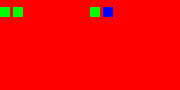

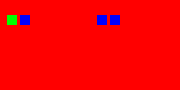

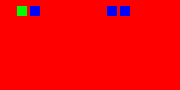

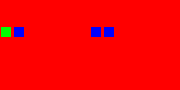

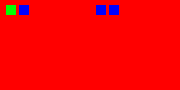

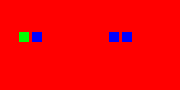

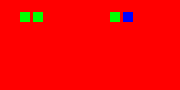

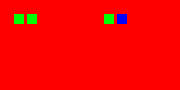

In [30]:
def plot_train(n):
    g = make_train_generator(42, IM_WIDTH, IM_HEIGHT, BOX_WIDTH, BOX_HEIGHT, MARGIN, N_CLASSES)
    for _ in range(n):
        X, y = next(g)
        display(PIL.Image.fromarray((np.concatenate([X, y], axis=1)*255).astype(np.uint8)))
plot_train(8)

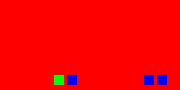

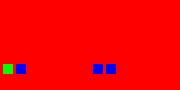

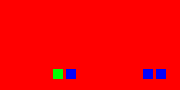

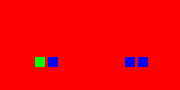

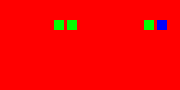

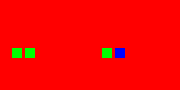

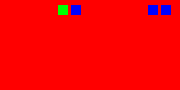

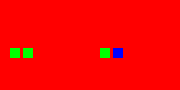

In [31]:
def plot_test(n):
    g = make_test_generator(42, IM_WIDTH, IM_HEIGHT, BOX_WIDTH, BOX_HEIGHT, MARGIN, N_CLASSES)
    for _ in range(n):
        X, y = next(g)
        display(PIL.Image.fromarray((np.concatenate([X, y], axis=1)*255).astype(np.uint8)))
plot_test(8)

In [32]:
n_batch = 4
train_generator = make_batch_generator(make_train_generator(42, IM_WIDTH, IM_HEIGHT, BOX_WIDTH, BOX_HEIGHT, MARGIN, N_CLASSES), n_batch)
dev_generator = make_batch_generator(make_test_generator(43, IM_WIDTH, IM_HEIGHT, BOX_WIDTH, BOX_HEIGHT, MARGIN, N_CLASSES), n_batch)
test_generator = make_batch_generator(make_test_generator(44, IM_WIDTH, IM_HEIGHT, BOX_WIDTH, BOX_HEIGHT, MARGIN, N_CLASSES), 1)
model = model_of(IM_WIDTH, IM_HEIGHT, N_CLASSES, N_CHANNELS)
#model.compile(loss=softmax_cross_entropy_with_logits_v2, optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.99), metrics=["accuracy"])
model.compile(loss=softmax_cross_entropy_with_logits_v2, optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

model.fit_generator(train_generator, steps_per_epoch=64, epochs=2, validation_data=dev_generator, validation_steps=10)

Epoch 1/2
64/64 [==============================] - 52s 808ms/step - loss: 0.1249 - acc: 0.9677 - val_loss: 0.0184 - val_acc: 0.9922
Epoch 2/2
64/64 [==============================] - 49s 758ms/step - loss: 0.0052 - acc: 0.9977 - val_loss: 6.9757e-04 - val_acc: 0.9998


左：予測．右：真値．

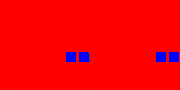

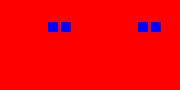

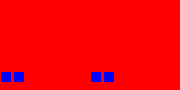

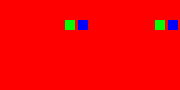

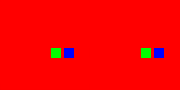

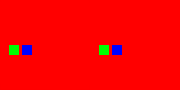

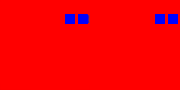

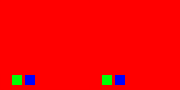

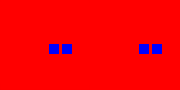

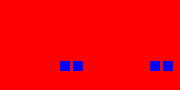

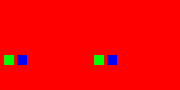

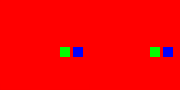

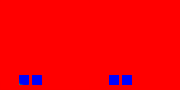

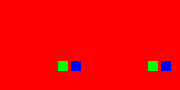

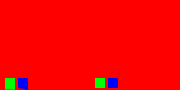

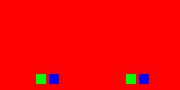

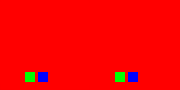

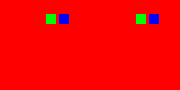

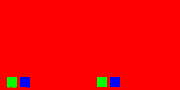

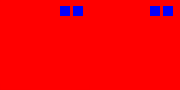

--


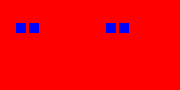

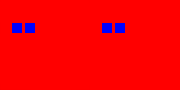

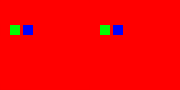

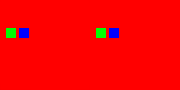

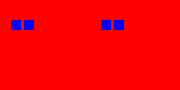

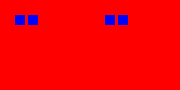

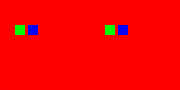

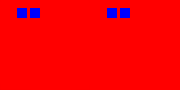

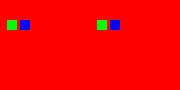

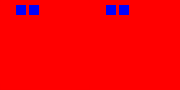

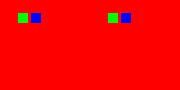

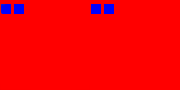

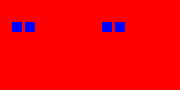

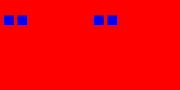

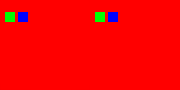

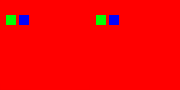

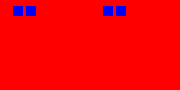

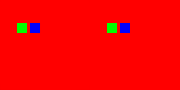

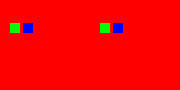

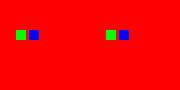

In [33]:
def check(g):
    X, y = next(g)
    y_pred = model.predict(X[:1, ...])
    display(PIL.Image.fromarray((255*np.exp(y_pred - sp.special.logsumexp(y_pred, axis=-1, keepdims=True))[0, ...]).astype(np.uint8)))
    display(PIL.Image.fromarray((255*y[0, ...]).astype(np.uint8)))

    
def check(g):
    X, y = next(g)
    y_pred = model.predict(X[:1, ...])
    aim_pred = (255*np.exp(y_pred - sp.special.logsumexp(y_pred, axis=-1, keepdims=True))[0, ...]).astype(np.uint8)
    aim_true = (255*y[0, ...]).astype(np.uint8)
    aim = np.concatenate([aim_pred, aim_true], axis=1)
    display(PIL.Image.fromarray(aim))

    
for _ in range(20):
    check(test_generator)
print("--")
for _ in range(20):
    check(train_generator)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 90, 90, 3)    0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 90, 90, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 90, 90, 32)   9248        conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 90, 90, 32)   25632       conv2d_55[0][0]                  
__________________________________________________________________________________________________
concatenat

In [35]:
tf.__version__

'1.11.0'